In [1]:
import deepchem as dc
import os

import numpy as np
# import tensorflow as tf

import matplotlib.pyplot as plt
import joblib

from rdkit import Chem

from load_input import load_pdbbind

from deepchem.models import AtomicConvModel
from deepchem.feat import AtomicConvFeaturizer


No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
Skipped loading some PyTorch models, missing a dependency. No module named 'torch_geometric'
No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


In [2]:

f1_num_atoms = 100  # maximum number of atoms to consider in the ligand
f2_num_atoms = 1000  # maximum number of atoms to consider in the protein
max_num_neighbors = 12  # maximum number of spatial neighbors for an atom

acf = AtomicConvFeaturizer(frag1_num_atoms=f1_num_atoms,
                      frag2_num_atoms=f2_num_atoms,
                      complex_num_atoms=f1_num_atoms+f2_num_atoms,
                      max_num_neighbors=max_num_neighbors,
                      neighbor_cutoff=4)
tasks, datasets, transformers = load_pdbbind(featurizer=acf,
                                             save_dir='.',
                                             data_dir='.',
                                             pocket=True,
                                             reload=False,
                                             set_name='core')


[18:53:49] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:53:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:53:50] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:53:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:53:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:53:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:53:51] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:53:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:53:52] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

# Transform Data

In [3]:
class MyTransformer(dc.trans.Transformer):
  def transform_array(x, y, w, ids):
    kept_rows = x != None
    X_reshaped = np.squeeze(x[kept_rows], axis=0)  # Remove the first dimension
    Y_reshaped = np.squeeze(y[kept_rows], axis=0)  # Remove the first dimension
    W_reshaped = np.squeeze(w[kept_rows], axis=0)  # Remove the first dimension
    ID_reshaped = np.squeeze(ids[kept_rows], axis=0)  # Remove the first dimension
    return X_reshaped, Y_reshaped, W_reshaped, ID_reshaped


In [4]:
datasets = [d.transform(MyTransformer) for d in datasets]
len(datasets)

/var/folders/56/f7d5v_xj0q5cnkv09f8tmfnw0000gn/T/ipykernel_11481/2209377302.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  kept_rows = x != None
/var/folders/56/f7d5v_xj0q5cnkv09f8tmfnw0000gn/T/ipykernel_11481/2209377302.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  kept_rows = x != None
/var/folders/56/f7d5v_xj0q5cnkv09f8tmfnw0000gn/T/ipykernel_11481/2209377302.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  kept_rows = x != None


3

# Split datasets into train, validation, test

In [9]:
train, val, test = datasets

In [23]:
val.y

array([-1.97400899, -0.08801763, -0.67597657,  0.70798832, -0.82975044,
        0.17882527, -0.62170344, -0.55838478, -0.69859037, -0.21465494,
        1.02458159,  0.1290749 ,  0.52255511, -1.34534521,  1.00649055,
        0.88889876, -1.0785023 , -1.57148326, -1.23679894])

In [24]:
val.X

array([[array([[-0.652, 11.65 , -6.54 ],
               [-0.849, 10.47 , -5.775],
               [-1.591, 10.501, -4.55 ],
               [-2.162, 11.671, -4.035],
               [-1.985, 12.83 , -4.764],
               [-1.237, 12.816, -6.04 ],
               [-1.235, 14.109, -6.513],
               [-2.068, 14.924, -5.644],
               [-2.396, 14.119, -4.504],
               [-0.284,  9.162, -6.226],
               [-0.068,  8.043, -5.4  ],
               [ 0.46 ,  7.054, -6.23 ],
               [ 0.562,  7.495, -7.482],
               [ 0.108,  8.836, -7.507],
               [ 0.821,  5.785, -5.837],
               [ 1.056,  6.905, -8.764],
               [ 0.   ,  0.   ,  0.   ],
               [ 0.   ,  0.   ,  0.   ],
               [ 0.   ,  0.   ,  0.   ],
               [ 0.   ,  0.   ,  0.   ],
               [ 0.   ,  0.   ,  0.   ],
               [ 0.   ,  0.   ,  0.   ],
               [ 0.   ,  0.   ,  0.   ],
               [ 0.   ,  0.   ,  0.   ],
               [

# ACNN

In [6]:
acm = AtomicConvModel(n_tasks=1,
                      frag1_num_atoms=f1_num_atoms,
                      frag2_num_atoms=f2_num_atoms,
                      complex_num_atoms=f1_num_atoms+f2_num_atoms,
                      max_num_neighbors=max_num_neighbors,
                      batch_size=4,
                      layer_sizes=[32, 32, 16],
                      learning_rate=0.003,
                      )
losses, val_losses = [], []
#max_epochs = 50
max_epochs = 1

metric = dc.metrics.Metric(dc.metrics.score_function.rms_score)
step_cutoff = len(train)//12

def val_cb(model, step):
  if step%step_cutoff!=0:
      return
  val_losses.append(model.evaluate(val, metrics=[metric])['rms_score']**2)  # L2 Loss
  losses.append(model.evaluate(train, metrics=[metric])['rms_score']**2)  # L2 Loss

print("BEGIN TRAIN")
acm.fit(train, nb_epoch=max_epochs, max_checkpoints_to_keep=1,
                callbacks=[val_cb])
print("DONE")


BEGIN TRAIN
DONE


# Visualize loss function 

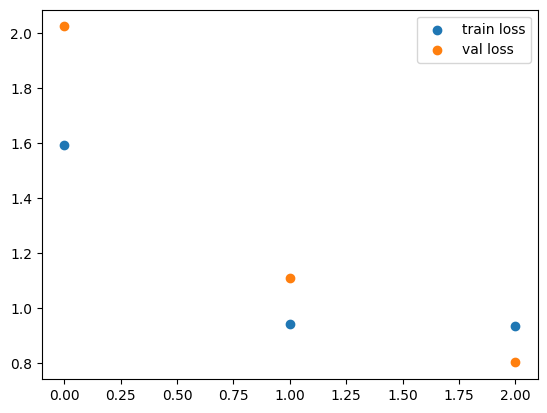

In [7]:
f, ax = plt.subplots()
ax.scatter(range(len(losses)), losses, label='train loss')
ax.scatter(range(len(val_losses)), val_losses, label='val loss')
plt.legend(loc='upper right')

# Predict

In [8]:
npa = acm.predict(test)
print(npa)

[[[-0.79486984]]

 [[ 0.29086393]]

 [[-0.00695908]]

 [[-0.803628  ]]

 [[ 0.46749705]]

 [[-0.04761034]]

 [[ 0.09064716]]

 [[-0.80803174]]

 [[ 0.1739586 ]]

 [[ 0.19884688]]

 [[ 0.4634704 ]]

 [[ 0.42159253]]

 [[ 0.25509793]]

 [[-0.4124623 ]]

 [[ 0.2743271 ]]

 [[ 0.21171647]]

 [[ 0.2914309 ]]

 [[ 0.38098896]]

 [[ 0.22854757]]

 [[ 0.4699642 ]]]


In [27]:
data = np.array(npa)

# Mapping Data with PDB 

In [28]:
mapping_dict = {}

for value, array in zip(test.ids, data):
    mapping_dict[value] = array

In [11]:
mapping_dict 

{'4de2': array([[-0.32044953]], dtype=float32),
 '2w66': array([[0.452116]], dtype=float32),
 '3ov1': array([[0.30610573]], dtype=float32),
 '3pe2': array([[0.47714704]], dtype=float32),
 '2ole': array([[-0.75211746]], dtype=float32),
 '2d1o': array([[0.48390386]], dtype=float32),
 '3cyx': array([[0.4732465]], dtype=float32),
 '1a30': array([[-1.3310952]], dtype=float32),
 '3f3e': array([[-1.7201221]], dtype=float32),
 '1os0': array([[0.49994108]], dtype=float32),
 '3g2n': array([[0.07807195]], dtype=float32),
 '1sln': array([[0.02046591]], dtype=float32),
 '2gss': array([[0.06073958]], dtype=float32),
 '3fk1': array([[0.3761527]], dtype=float32),
 '1igj': array([[0.4957866]], dtype=float32),
 '3udh': array([[0.13985938]], dtype=float32),
 '3pxf': array([[-0.7110254]], dtype=float32),
 '3ao4': array([[-0.41258806]], dtype=float32),
 '3uo4': array([[0.46818817]], dtype=float32),
 '1f8b': array([[0.5050608]], dtype=float32)}